In [8]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt


In [25]:
os.chdir("/home/jrchen/git-project/kpts_test")

# exp_path = "link/datasets/nrealX/MoveRightHandTestDemo/test2_2023-03-15-16-58-21"
# exp_path = "link/datasets/nrealX/MoveRightFixM2P/test2_2023-03-20-18-17-01"
exp_path = "link/datasets/nrealX/MoveRightFixM2P/test2_2023-03-20-18-55-34"


wrong_rec = False

root_dir_ori = os.path.join(exp_path, "hand_record_data")
root_dir_pred = os.path.join(exp_path, "predicted_data")

save_dir = root_dir_ori.replace("datasets", "outputs").replace("hand_record_data", "kalmanExp")
os.makedirs(save_dir, exist_ok=True)


In [26]:
if 'Left' in root_dir_ori:
    test_left = True
elif 'Right' in root_dir_ori:
    test_left = False
else:
    raise KeyError

if wrong_rec:
    test_left = not test_left

if test_left:
    print("test_left")
else:
    print("test_right")    

test_right


In [27]:
file_list_ori = os.listdir(root_dir_ori)
file_list_ori = list(filter(lambda x: "inference" in x, file_list_ori))
file_list_ori.sort()

file_list_pred = os.listdir(root_dir_pred)
file_list_pred = list(filter(lambda x: "predicted" in x, file_list_pred))
file_list_pred.sort()

print(f"file_list_ori:{len(file_list_ori)}")
print(f"file_list_pred:{len(file_list_pred)}")

file_list_ori:883
file_list_pred:1754


In [28]:
ori_info = {
    "timestamp": [],
    "is_tracked": {
        "left": [],
        "right": []
    },
    "keypoints": {
        "left": [],
        "right": []
    }
}

pred_info = {
    "timestamp": [],
    "is_tracked": {
        "left": [],
        "right": []
    },
    "keypoints": {
        "left": [],
        "right": []
    }
}

# ori info 
for index, filename in enumerate(file_list_ori):
    with open(os.path.join(root_dir_ori, filename), 'r') as f:
        data = json.load(f)

    ts = data["current_time_nanos"] / 1e9
    ori_info["timestamp"].append(ts)
    left_tracked, right_tracked = data["leftright_hand_status"]
    ori_info["is_tracked"]["left"].append(left_tracked)
    ori_info["is_tracked"]["right"].append(right_tracked)
    if left_tracked:
        keypoints = np.array(data["mid_inference"]["09_worldmano"]["lefthand"]).reshape(23,3)
        ori_info["keypoints"]["left"].append(keypoints)
    else:
        ori_info["keypoints"]["left"].append(None)
    if right_tracked:
        keypoints = np.array(data["mid_inference"]["09_worldmano"]["righthand"]).reshape(23,3)
        ori_info["keypoints"]["right"].append(keypoints)
    else:
        ori_info["keypoints"]["right"].append(None)

# pred info 
for index, filename in enumerate(file_list_pred):
    with open(os.path.join(root_dir_pred, filename), 'r') as f:
        data = json.load(f)
    
    ts = data["predicted_time_nanos"] / 1e9
    pred_info["timestamp"].append(ts)
    left_tracked, right_tracked = data["leftright_hand_status"]
    pred_info["is_tracked"]["left"].append(left_tracked)
    pred_info["is_tracked"]["right"].append(right_tracked)
    if left_tracked:
        keypoints = np.array(data["predicted"]["lefthand"]["keypoints"]).reshape(23,3)
        pred_info["keypoints"]["left"].append(keypoints)
    else:
        pred_info["keypoints"]["left"].append(None)
    if right_tracked:
        keypoints = np.array(data["predicted"]["righthand"]["keypoints"]).reshape(23,3)
        pred_info["keypoints"]["right"].append(keypoints)
    else:
        pred_info["keypoints"]["right"].append(None)

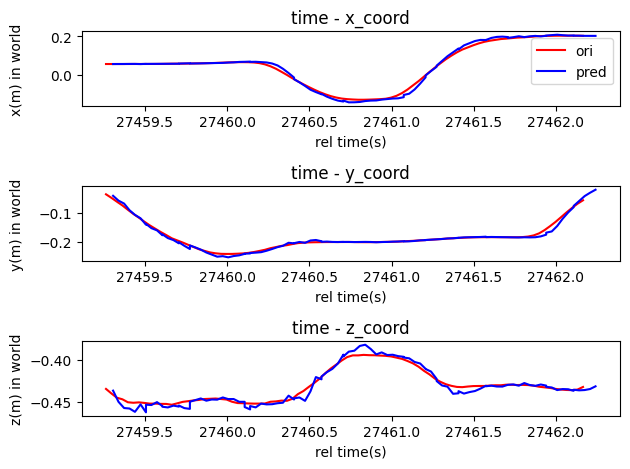

In [29]:
start_time_ori = int(len(file_list_ori)* 5/ 10)
end_time_ori = int(len(file_list_ori)*6/10)

start_time_pred = int(len(file_list_pred)* 5 / 10)
end_time_pred = int(len(file_list_pred)*6/10)

for index in range(1):
    time_list_tmp_ori = []
    keypoints_tmp_ori = []
    if test_left:
        for i in range(start_time_ori, end_time_ori):
            if ori_info["is_tracked"]["left"][i]:
                time_list_tmp_ori.append(ori_info["timestamp"][i])
                keypoints_tmp_ori.append(ori_info["keypoints"]["left"][i][index])
    else:
        for i in range(start_time_ori, end_time_ori):
            if ori_info["is_tracked"]["right"][i]:
                time_list_tmp_ori.append(ori_info["timestamp"][i])
                keypoints_tmp_ori.append(ori_info["keypoints"]["right"][i][index])
    
    time_list_tmp_pred = []
    keypoints_tmp_pred = []
    if test_left:
        for i in range(start_time_pred, end_time_pred):
            if pred_info["is_tracked"]["left"][i]:
                time_list_tmp_pred.append(pred_info["timestamp"][i])
                keypoints_tmp_pred.append(pred_info["keypoints"]["left"][i][index])
    else:
        for i in range(start_time_pred, end_time_pred):
            if pred_info["is_tracked"]["right"][i]:
                time_list_tmp_pred.append(pred_info["timestamp"][i])
                keypoints_tmp_pred.append(pred_info["keypoints"]["right"][i][index])

    keypoints_np_ori = np.array(keypoints_tmp_ori)
    keypoints_np_pred = np.array(keypoints_tmp_pred)

    fig = plt.figure()
    plt.subplot(3, 1, 1)
    plt.title("time - x_coord")
    plt.plot(time_list_tmp_ori, keypoints_np_ori[:, 0], "r", label='ori')
    plt.plot(time_list_tmp_pred, keypoints_np_pred[:, 0], "b", label='pred')
    plt.xlabel("rel time(s)")
    plt.ylabel("x(m) in world")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("time - y_coord")
    plt.plot(time_list_tmp_ori, keypoints_np_ori[:, 1], "r")
    plt.plot(time_list_tmp_pred, keypoints_np_pred[:, 1], "b")
    plt.xlabel("rel time(s)")
    plt.ylabel("y(m) in world")

    plt.subplot(3, 1, 3)
    plt.title("time - z_coord")
    plt.plot(time_list_tmp_ori, keypoints_np_ori[:, 2], "r")
    plt.plot(time_list_tmp_pred, keypoints_np_pred[:, 2], "b")
    plt.xlabel("rel time(s)")
    plt.ylabel("z(m) in world")

    fig.align_labels()
    plt.tight_layout()

    plt.savefig(f"{save_dir}/point_{index}.png")
                